# PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow!

In [ ]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to the data (training)",
                      4: "make predictions (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to the data (training)',
 4: 'make predictions (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [ ]:
import torch
from torch import nn ## nn contains all of PyTorch's building blocks for NN
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.6.0+cu124'

## 1. Data (Preparing and loading)

Data can be almost anything... in machine learning.

* Excel spreadsheet
* Images
* Videos
* Audio
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns

To showcase this, let's create some *known* data using the linear regression formula:

We'll use a linear regression formula to make a straight line with *known*  **parameters**

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create some data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10],

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len(y)

(50, 50)

### Splitting data into training and tests sets (**important**)

Let's create a training and test set with our data

**Goal**: generalization --> ability for machine learning model to perform well on data it hasn't seen yet.



In [ ]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

"Visualize, visualize, visualize!"

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions != None:
    # Plot the predictions in red (predictions in the future)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

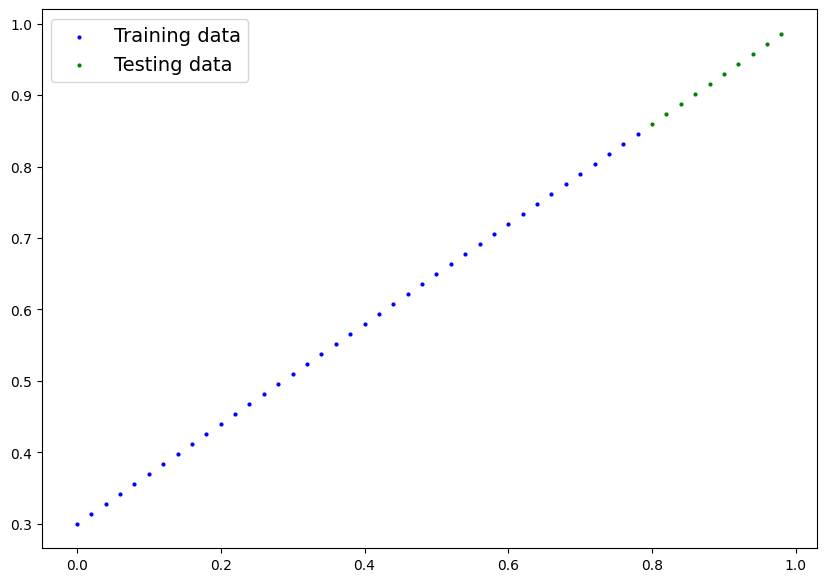

In [ ]:
plot_predictions()

## 2. Build model

Our first PyTorch model!

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) to the ideal values

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation


In [ ]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything inherits from nn.module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # Forward defines the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # This is the linear regression formula

### PyTorch model building essentials

* torch.nn - contains all the building for computational graphs
* torch.nn.Parameter - what paremeters should our model try and learn.
* torch.nn.Model - The base class for all neural network modules, if you subclass it, you should override forward().
* torch.optim - This is where optimizers live, will help with data representations
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation


### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

We can check our parameters using `.parameters()`

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of Model (subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

Let's see how well it predicts `y_test` based on `X_test`

When we pass data through our model, it's going to run it through the forward() method

In [ ]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

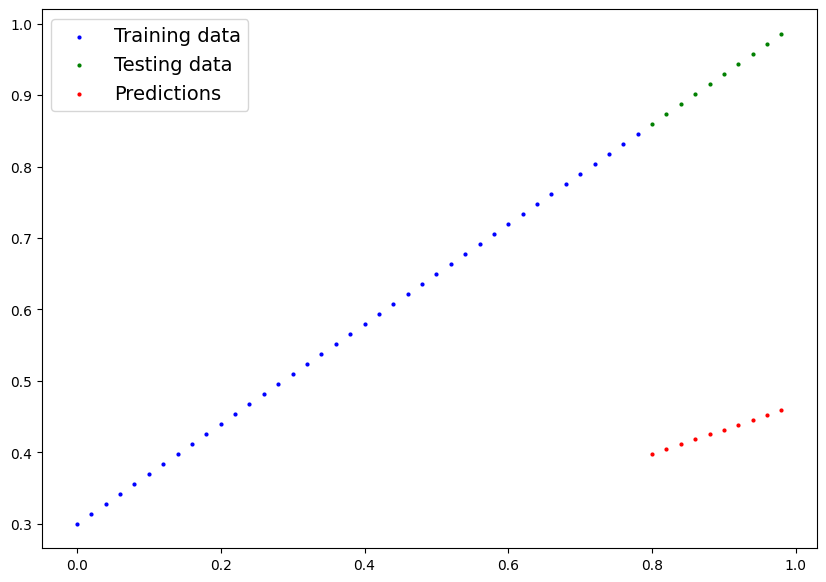

In [ ]:
plot_predictions(predictions=y_preds)

### 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters to some *known* parameters.

from a poor representation of data to a better representation of data

One way to measure how poor or how wrong model's predictions are; is to use a loss function:

* Note: Loss function may also be called cost function or criterion (same meaning)

Things we need to train:

* **Loss Function:** A function to measure how wrong your model's predicitions are to the ideal outputs, lower is better.

* **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters (e.g. weight and bias) to improve loss function.
  * `params` -The model parameters you'd like to optimize e.g. **params=model_0.parameters()**
  * `lr` (learning rate) -The learning rate is a *hyperparameter* (defines how big/small the optimizer changes the parameters with each step)

And specifically for PyTorch, we need:

* A training loop
* A testing loop


In [ ]:
# Setup a Loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr=learning rate


### Building a training loop (and a testing loop) in PyTorch

A couple of things we need (training loop):

0. Loop through data

1. Forward pass (this involves data moving through our data forward functions) - aka forward propagation

2. Calculate loss (compare forward pass predicitions to ground truth labels)

3. Optimizer zero grad

4. Loss backward - move backwards through network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)

5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)


In [ ]:
# An epoch is one loop through the data... (hyperparameter b/c we set it ourselves)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # Train mode in PyTorch set all parameteres that requires gradients to "requires gradients"

  # 1. Forward pass
  y_preds = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_preds, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on loss with respect to parameters of model
  loss.backward()

  # 5. Step the optimizer (Perform gradient descent)
  optimizer.step() # how optimizer changes will accumulate through loop ... we have to zero them in step 3

### Testing
  model_0.eval() # turns off gradient tracking
  with torch.inference_mode(): # turns off gradient tracking & a couple more things not needed for testing
    # 1 Do the forward pass

    test_preds = model_0(X_test)
    # 2 Calculate the loss
    test_loss = loss_fn(test_preds, y_test)
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

  # Print out model state_dict()
  print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
OrderedDict([('weights', tensor([0.3484])), ('bias', tensor([0.1588]))])
OrderedDict([('weights', tensor([0.3523])), ('bias', tensor([0.1688]))])
OrderedDict([('weights', tensor([0.3562])), ('bias', tensor([0.1788]))])
OrderedDict([('weights', tensor([0.3601])), ('bias', tensor([0.1888]))])
OrderedDict([('weights', tensor([0.3640])), ('bias', tensor([0.1988]))])
OrderedDict([('weights', tensor([0.3679])), ('bias', tensor([0.2088]))])
OrderedDict([('weights', tensor([0.3718])), ('bias', tensor([0.2188]))])
OrderedDict([('weights', tensor([0.3757])), ('bias', tensor([0.2288]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
OrderedDict([('weights', tensor([0.3835])), ('bias', tenso

In [ ]:
import numpy as np

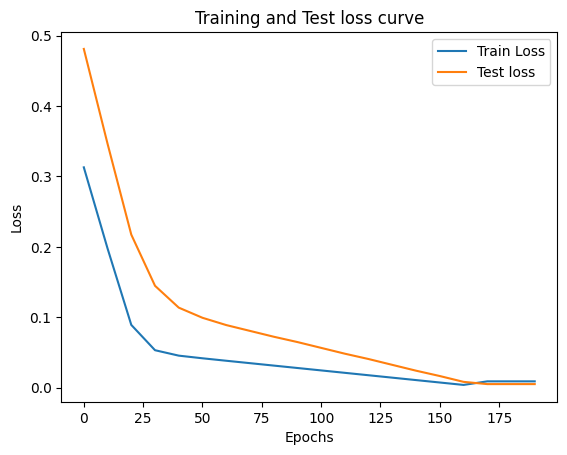

In [ ]:
# Plot the loss curve
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and Test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

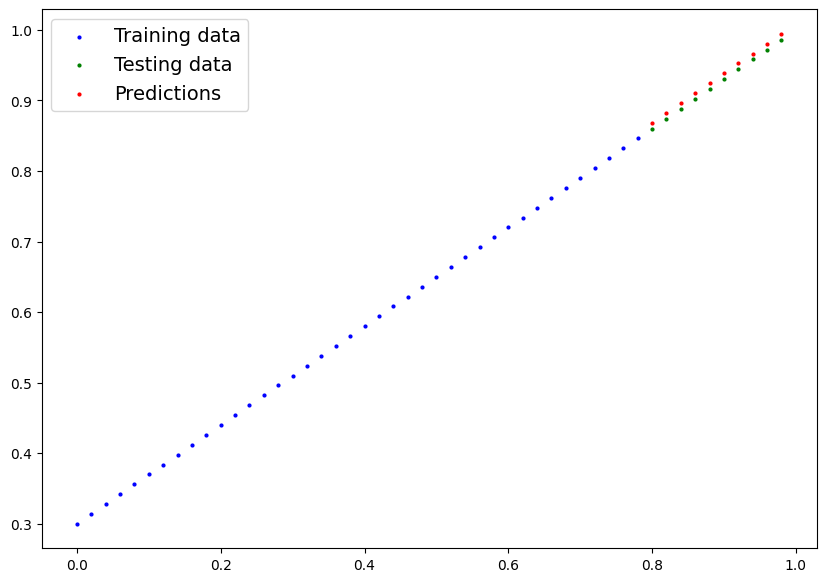

In [ ]:
with torch.inference_mode():
  y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

In [ ]:
weight, bias

(0.7, 0.3)

### Saving a model in PyTorch

There are three main methods:

1. `torch.save()` -allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` -allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()`

In [ ]:
# Saving our PyTorch model
from pathlib import Path

# `. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that

In [ ]:
# To load in a saved state_dict, we have to instantiate a new instance of our model class
loadded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (This will update the new instance with updated parameters)

loadded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loadded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

### 6. Putting it all together

Let's go back through steps above and see it all in one place

In [ ]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.6.0+cu124'

Create device-agnostic code.

This means if we have GPU, our code will use it (for potentially faster computing).

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

In [ ]:
# Create some data using the linear regression formula of y = weight * X + Bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and Y (features and labels)
x = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * x + bias
x[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# Split data
train_split = int(0.8 * len(x))
x_train, y_train = x[:train_split], y[:train_split]
x_test, y_test = x[train_split:], y[train_split:]
len(x_train), len(y_train), len(x_test), len(y_test)

(40, 40, 10, 10)

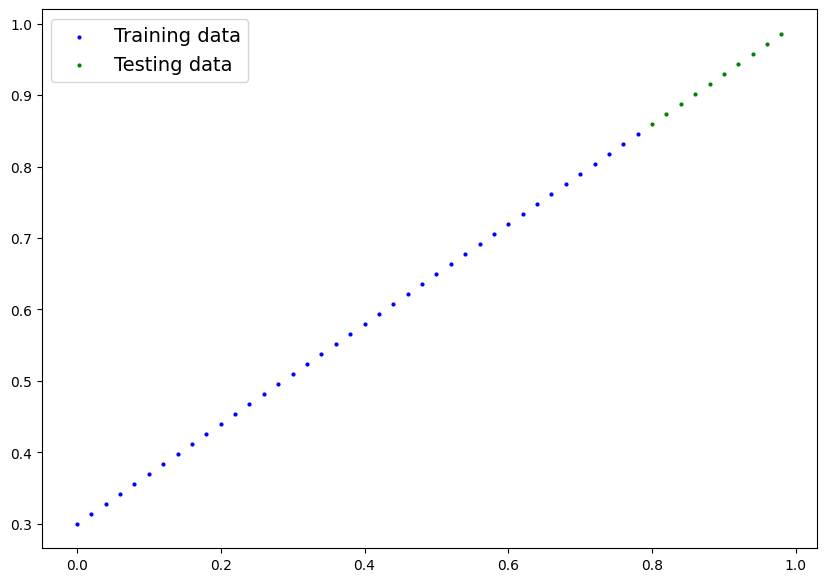

In [ ]:
# Plot the data
# Note: if you don't have the plot_predictions() function loaded, this wil error
plot_predictions(x_train, y_train, x_test, y_test)

### 6.2 Building a PyTorch Linear model

In [ ]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    # Use nn.Linear()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [ ]:
# Setup loss function
loss_fn = nn.L1Loss() # Same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on target device (device agnostic code for data)
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_preds = model_1(x_train)

  # 2. Calculate the loss
  loss = loss_fn(y_preds, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_preds = model_1(x_test)
    test_loss = loss_fn(test_preds, y_test)

  # Print out what's happening

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")


Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test Loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test Loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test Loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test Loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test Loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test Loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test Loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test Loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.4 Making and evaluating predictions

In [ ]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(x_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

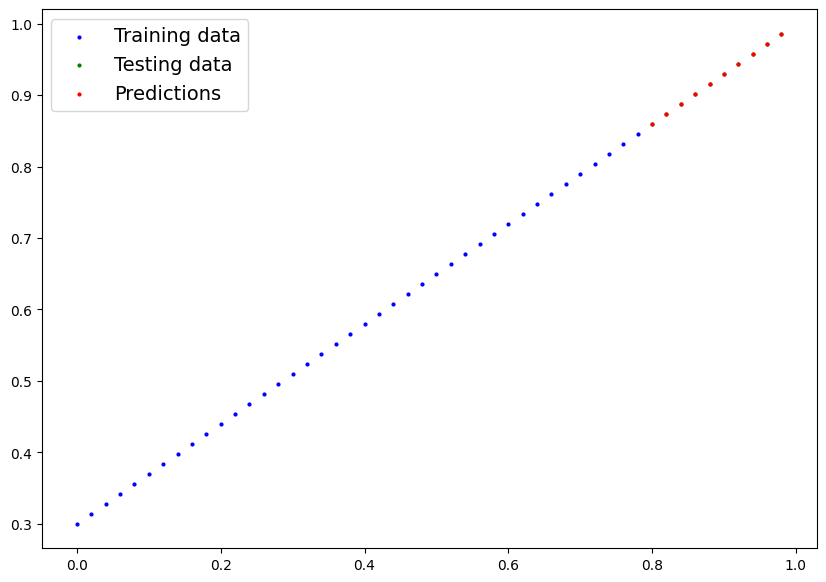

In [ ]:
# Check out our model predictions visually
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving and Loading a trained model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
# Load a PyTorch Model

# Create a new instance of linear regression model V2
loadded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict
loadded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Put the loadded model to device
loadded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
next(loadded_model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
loadded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [ ]:
# Evaluate loadded model
loadded_model_1.eval()
with torch.inference_mode():
  loadded_model_1_preds = loadded_model_1(x_test)
y_preds == loadded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')